# Tutorial: Variational Autoencoder


In this exercise, we will focus on the problem of density estimation. We will use the well-known `MNIST` dataset to train a Variational Autoencoder that will learn to approximate the distribution of the data and consequently, will be able to generate 'realistic' images. We will use the package `pytorch`, which allow us to perform automatic differentiation.

This notebook is mostly based on the following notebok: 

https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb



**Note:** It is possible to run the code in CPU or GPU mode by changing the value of the variable `device`. To try the GPU mode, you can upload the notebook to Google Colab and then select then choose GPU execution mode.  See the following link to learn how to do it https://www.marktechpost.com/2019/06/09/getting-started-with-pytorch-in-google-collab-with-free-gpu/

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.distributions import Normal, Bernoulli, kl_divergence
from torchvision.utils import make_grid as make_image_grid

from torch.distributions import MultivariateNormal
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

from torch.autograd import Variable

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

from tqdm import tnrange
from scipy.stats import norm
from sklearn.manifold import TSNE


%matplotlib inline

# use seaborn plotting defaults
import seaborn as sns; sns.set()
print('PyTorch version: {}'.format(torch.__version__))
if torch.cuda.is_available():
    print('GPU: {}'.format(torch.cuda.current_device()))
else:
    print('CPU mode!')

PyTorch version: 1.7.1
GPU: 0


### Load data

In [28]:
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

### Hyperparameters

In [29]:
latent_dim = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Definition of the VAE

Lets create the Variational Autoencoder class. It contains the definition of the NNs that represente the inference and generative modules.

The generative model with parameters $\theta$ is
\begin{align}
p_\theta(\mathbf{z}, \mathbf{x}) = p_\theta(\mathbf{x}|\mathbf{z}) p(\mathbf{z}) \qquad  p_\theta(\mathbf{x}|\mathbf{z})=\mathcal{N}\Big(\mu_\theta(\mathbf{z}), \sigma^2\mathbf{I} \Big) \qquad  p(\mathbf{z}) = \mathcal{N}\Big(\mathbf{0}, \mathbf{I}\Big)
\end{align}

Our approximation to the posterior $p(\mathbf{z}|\mathbf{x})$ is of the form
\begin{align}
p(\mathbf{z}|\mathbf{x}) \approx q_\phi(\mathbf{z}|\mathbf{x})=\mathcal{N}\Big(\mu_\phi(\mathbf{x}),\Sigma_\phi(\mathbf{x})\Big),
\end{align}
where

- $\mu_\phi(\mathbf{x})$ --> Given by a Neural Network with parameter vector $\phi$ and input $\mathbf{x}$

- $\Sigma_\phi(\mathbf{x})$ --> Diagonal covariance matrix, where the log of the main diagonal is constructed by a Neural Network with parameter vector $\phi$ and input $\mathbf{X}$

**Note:** Some of the parameters  can be shared between $\mu_\phi(\mathbf{x})$ and $\Sigma_\phi(\mathbf{x})$


In [30]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=500):
        super(VAE,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(784, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 784), nn.Sigmoid()
        )
            
    def encode(self, x):
        mean_logvar = self.encoder(x)
        hidden_dim = mean_logvar.size(-1)//2
        
        mean = mean_logvar[..., :hidden_dim]
        logvar = mean_logvar[..., hidden_dim:]
        
        return mean, logvar
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)
    
    def sample_normal(self, mean, logvar):
        std = torch.exp(logvar*0.5)
        return Normal(loc=mean, scale=std).rsample()  # rsample means sampling using the reparametrization trick
    
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sample_normal(z_mean, z_logvar)
        x_out = self.decode(z)
        
        return x_out, z_mean, z_logvar

model = VAE()

### Evidence Lower Bound (ELBO)

We want to optimize the ELBO, which is a lower bound on the log marginal likelihood of our data. The ELBO for a single data sample $\mathbf{x}$ is

\begin{align}
\text{ELBO}(\mathbf{x},\theta,\phi) \triangleq \mathbb{E}_{q}\left[\log  p_\theta(\mathbf{x}|\mathbf{z})\right] - D_{KL}(q_\phi(\mathbf{z}|\mathbf{x})||p(\mathbf{z})) ,
\end{align}

where $D_{KL}(q_\phi(\mathbf{z}|\mathbf{x})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
D_{KL}(q_\phi(\mathbf{z}|\mathbf{x})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\Sigma(\mathbf{x})\right)+\left(\mu(\mathbf{x})^T\mu(\mathbf{x})\right)-2-\log\det \left(\Sigma(\mathbf{x})\right) \right]
\end{align}

In [36]:
def nll_gauss(mean, std, x):
    x_dist = Normal(loc=mean, scale=std)
    x_dist = Bernoulli(probs=mean)
    return -x_dist.log_prob(x).sum()

In [37]:
def ELBO(x, z_mu, z_logvar, out_mean):
    out_std = torch.ones_like(out_mean)
    
    z_post = Normal(loc=z_mu, scale=torch.exp(z_logvar * 0.5))
    z_prior = Normal(loc=torch.zeros_like(z_mu), scale=1.)
    
    # Compute loss
    kld_loss = kl_divergence(z_post, z_prior).sum()
    nll_loss = nll_gauss(out_mean, out_std, x)

    assert not torch.isnan(nll_loss).any(), print('{}\n{}\n{}'.format(Qz_x_sample, Qz_x_mean, Qz_x_std))
    assert not torch.isnan(kld_loss).any()

    elbo = -(nll_loss + kld_loss) / x.size(0) 
    loss_dict = {'KL_z': kld_loss.data.cpu().numpy(),
                 'LL': -nll_loss.data.cpu().numpy(),
                 'ELBO': elbo.data.cpu().numpy()}

    return elbo, loss_dict

### Method to perform ELBO optimization

Create a new method that implements a method `train_step` to perform a SGD step over the variational bound (ELBO)

In [38]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [39]:
# Training
def train(model, optimizer, dataloader, epochs=15):
    elbo_list = []
    for epoch in tnrange(epochs,desc='Epochs'):
      for images, _ in dataloader:
        x_in = images.to(device)
        optimizer.zero_grad()
        x_out_mean, z_mu, z_logvar = model(x_in)
        elbo, loss_dict = ELBO(x_in, z_mu, z_logvar, x_out_mean)
        negative_elbo = -elbo # We want to minimize the negative of the ELBO
        negative_elbo.backward() 
        optimizer.step()
        elbo_list.append(elbo.data.cpu().numpy())
    return elbo_list


In [40]:
model.to(device)
elbo_list = train(model,optimizer,trainloader, epochs=15)

<ipython-input-39-7599f45ac1c6>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs,desc='Epochs'):


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

### Plot the results

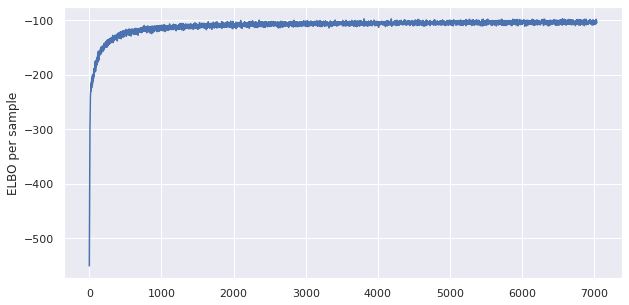

In [41]:
# Evolution of ELBO per sample
model.eval()
plt.figure(figsize=(10,5))
plt.plot(elbo_list)
plt.ylabel('ELBO per sample')
plt.show()

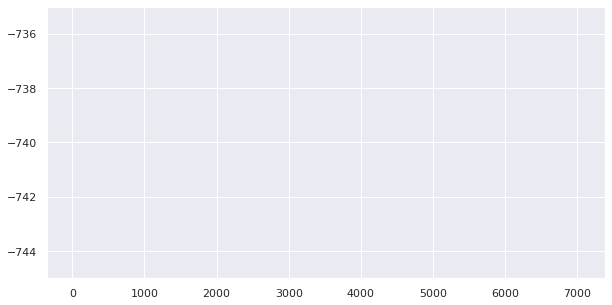

In [42]:
# Visualize moving average of ELBO
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(-745,-735)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(elbo_list)

In [67]:
# Testing
@torch.no_grad()
def test(model,dataloader):
    running_loss = 0.0
    for images, _ in dataloader:
        x_in = images.to(device)
        x_out_mean, z_mu, z_logvar = model(x_in)
        elbo, loss_dict = ELBO(x_in, z_mu, z_logvar, x_out_mean)
        running_loss = running_loss + (elbo.data*x_in.size(0))
    return running_loss/len(dataloader.dataset)

test_loss = test(model,testloader)
print('ELBO test: {}'.format(test_loss.cpu().numpy()))

ELBO test: -103.87580108642578


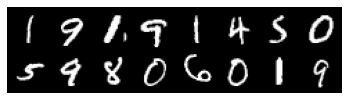

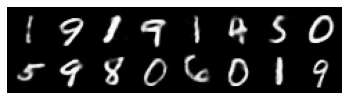

In [68]:
# Visualize VAE input and reconstruction
@torch.no_grad()
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = images.to(device)
    x_out,_,_ = model(x_in)
    x_out = x_out.data.cpu()
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,testloader)

torch.Size([10000, 20])


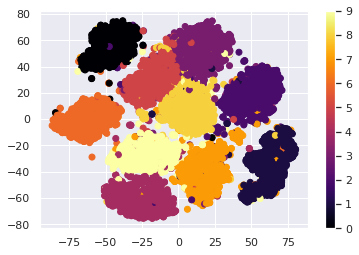

In [66]:
@torch.no_grad()
def visualize_latent_space(model, dataloader):
    z_means, all_labels = [], []
    
    for images,labels in iter(dataloader):
        z_mu, _ = model.encode(images.to(device))
        z_means.append(z_mu.cpu())
        all_labels = np.append(all_labels,labels.cpu())
    
    z_means = torch.cat(z_means, dim=0)
    print(z_means.size())
    z_embedded = TSNE(n_components=2).fit_transform(z_means)
    plt.scatter(z_embedded[:, 0],z_embedded[:, 1], c=all_labels, cmap='inferno')
    plt.colorbar()
    plt.show()
visualize_latent_space(model, testloader)

In [52]:
# Train, test and visualize reconstruction using a 2D latent space
model2 = VAE(latent_dim=2)
model2.to(device)
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = train(model2, optimizer2, trainloader)
test2_loss = test(model2,testloader)

<ipython-input-39-7599f45ac1c6>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(epochs,desc='Epochs'):


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

tensor(-151.5813, device='cuda:0')


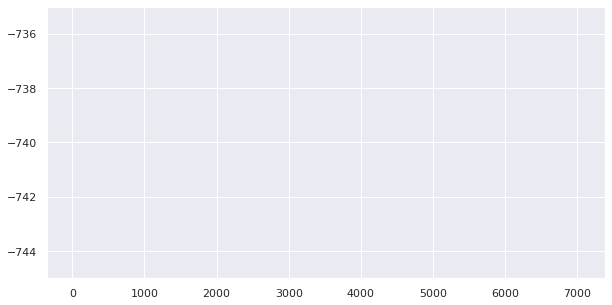

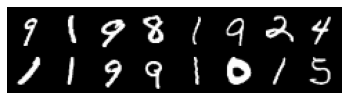

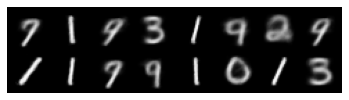

In [53]:
print(test2_loss)
visualize_losses_moving_average(train2_losses)
visualize_mnist_vae(model2,testloader)

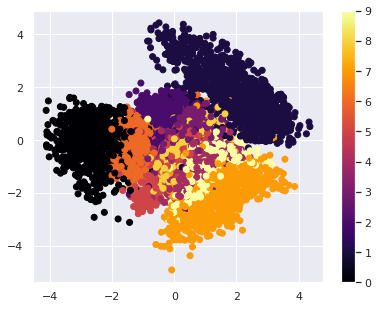

In [54]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encode(images.to(device))
        z_means_x = np.append(z_means_x,z_means[:,0].data.cpu())
        z_means_y = np.append(z_means_y,z_means[:,1].data.cpu())
        all_labels = np.append(all_labels,labels.cpu())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

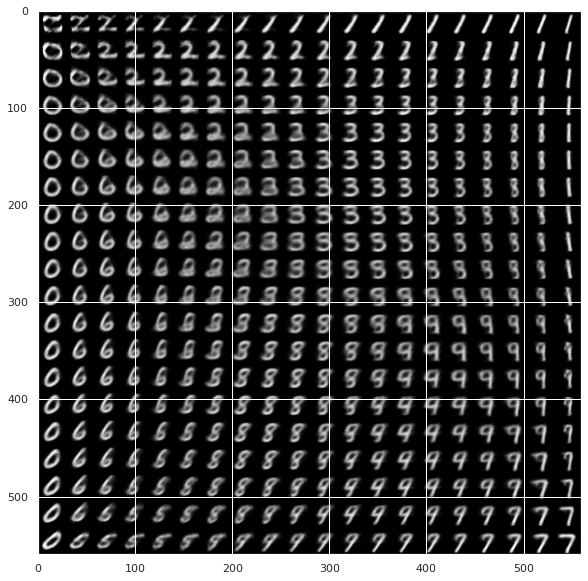

In [55]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = torch.FloatTensor([[x,y]]).to(device)
            image = model.decode(z)
            image = image.data.cpu().numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='gray')
    plt.show()

visualize_decoder(model2)